# Frequency filtering and Color

In [3]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift,ifftshift
import matplotlib.pyplot as plt
from PIL import Image

def imshow(I,title=None,size=500):
    """ display an image with a specific size """
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()


## Frequency filtering

In [4]:
def computeFT(I):
    """ Array -> Array[complex] """
    return fft2(I)

def toVisualizeLogFT(If):
    """ Array[complex] -> Array[float] """
    return np.log(1+np.abs(fftshift(If)))

# Recall: this function set to 1 pixels at euclidean distance(fc) from the center(null frequency).
def idealLowPassFilter(n,m,fc):
    # create an empty filter
    filter = np.arange(n*m).reshape(n,m)
    
    # fill it with values
    for i in range(n):
        for j in range(m):
            if (i-n/2)**2 + (j-m/2)**2 < fc**2:
                filter[i][j] = 1
            else:
                filter[i][j] = 0   
    return filter

# Performs low pass filtering on image I with cutoff frequency fc.
def lowPass(I,fc):
    cSpectrum = fftshift(computeFT(I))
    idealFilter = idealLowPassFilter(I.shape[0],I.shape[1],fc)
    filteredSpectrum = cSpectrum*idealFilter
    IDFT = ifft2(ifftshift(filteredSpectrum))
    rctImage = IDFT.real
    return rctImage

Experimenting lowPass(I,fc) function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.


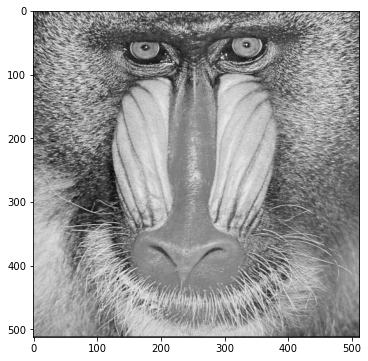

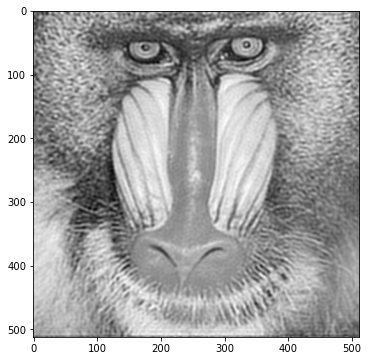

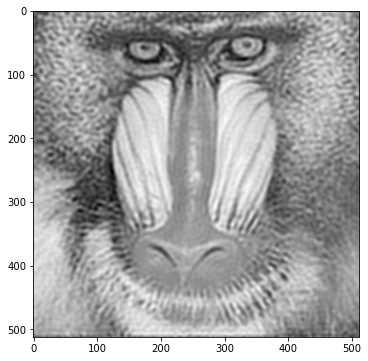

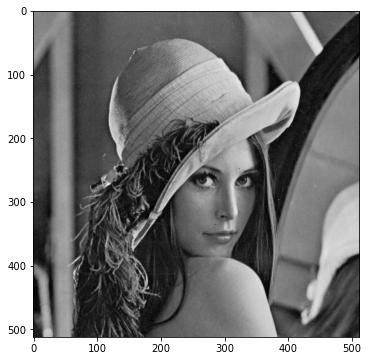

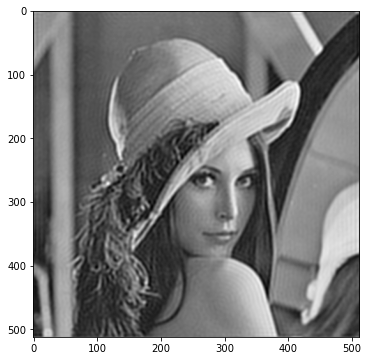

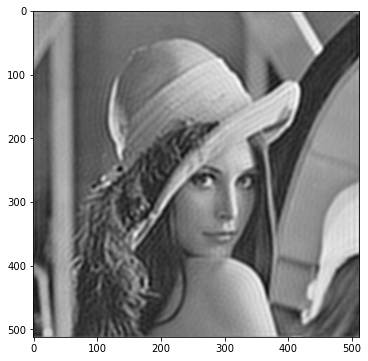

In [5]:
mandrill = np.array(Image.open('img/mandrill.png'))
lena = np.array(Image.open('img/lena.jpg'))

imshow(mandrill)
imshow(lowPass(mandrill,80))
imshow(lowPass(mandrill,60))
imshow(lena)
imshow(lowPass(lena,75))
imshow(lowPass(lena,60))

# Observations;
# increment of gibbs ringing artifacts(additional lines appears in the image)
# smooth edges
    
# Example Usages; 
# 1. Noise reduction
# 2. Eliminate alising while applying subsample

## Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. $(d-1)/2$ lines and columns should be added to each side of the image to apply this filter. The image must be surrounded by zero values.

In [6]:
def imagePad(I,h):
    # filter size
    dx = h.shape[0]
    dy = h.shape[1]
    
    # construct the new image size
    image = np.arange((I.shape[0]+(dx-1))*(I.shape[1]+(dy-1))).reshape((I.shape[0]+(dx-1)),(I.shape[1]+(dy-1)))
    
    # fill the image with values
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i < (dx-1)/2 or i >= I.shape[0]+(dx-1)/2:
                image[i][j] = 0
            elif j < (dy-1)/2 or j >= I.shape[1]+(dy-1)/2:
                image[i][j] = 0
            else:
                image[i][j] = I[int(i-(dx-1)/2)][int(j-(dy-1)/2)]
                
    return image

def conv2(I,h):
    # padding process
    image = imagePad(I,h)
    
    # create new empty image for filling new values
    filteredImage = np.arange(I.shape[0]*I.shape[1]).reshape(I.shape[0],I.shape[1])
    paddingSizeX = int((h.shape[0]-1)/2)
    paddingSizeY = int((h.shape[1]-1)/2)
    
    # filter reversing process
    revH = h
    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            revH[h.shape[0]-(i+1)][h.shape[1]-(i+1)] = h[i][j]
    
    # borders without zero-padding (C : column, R : row)
    minC = paddingSizeX
    maxC = int(image.shape[0]-paddingSizeX)
    minR = paddingSizeY
    maxR = int(image.shape[1]-paddingSizeY)
    
    # apply filter to the image
    for i in range(minC,maxC):
        for j in range(minR,maxR):
            newPixelValue = 0
            for x in range(h.shape[0]):
                for y in range(h.shape[1]):
                    newPixelValue += image[int(i-paddingSizeX+x)][int(j-paddingSizeY+y)]*revH[x][y]
            filteredImage[int(i-paddingSizeX)][int(j-paddingSizeY)] = newPixelValue
            
    return filteredImage

def createKernel(d):
    kernel = np.empty([d,d], dtype = float)
    for i in range(d):
        for j in range(d):
            kernel[i][j] = 1/(d**2)
    return kernel

Experimenting linear filtering with mean filter of size $3\times3$, $5\times 5$ and $7\times 7$.

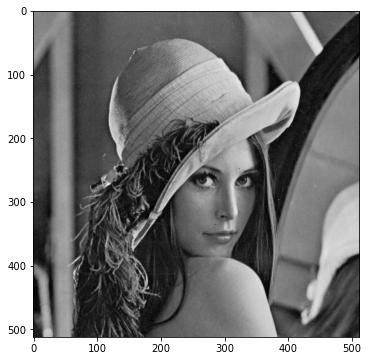

filtering...


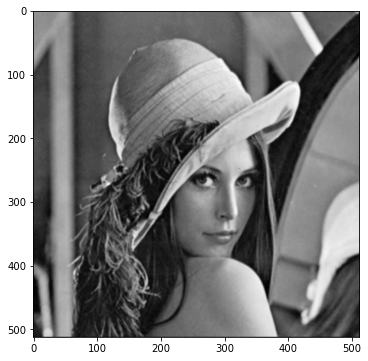

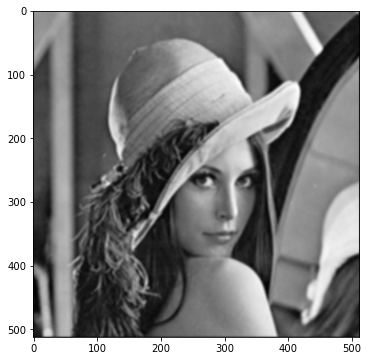

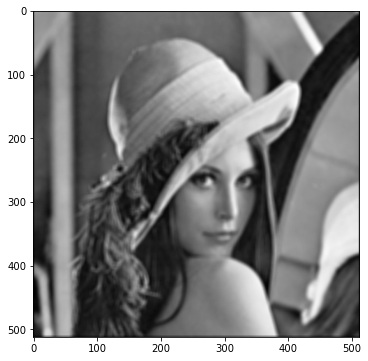

In [7]:
lena = np.array(Image.open('img/lena.jpg'))
imshow(lena)

# filters
filter3x3 = createKernel(3)
filter5x5 = createKernel(5)
filter7x7 = createKernel(7)

# filtering process
print("filtering...")
filteredImage3x3 = conv2(lena,filter3x3)
filteredImage5x5 = conv2(lena,filter5x5)
filteredImage7x7 = conv2(lena,filter7x7)

# visualize results
imshow(filteredImage3x3)
plt.show()
imshow(filteredImage5x5)
plt.show()
imshow(filteredImage7x7)
plt.show()


# As we increase the size of the kernel, more blur is added to the image. And this means the edges in the image are
# becoming more smooth. In other words, we are losing more high frequencies as we increase the kernel size.

Displaying the transfert function of these mean filters.

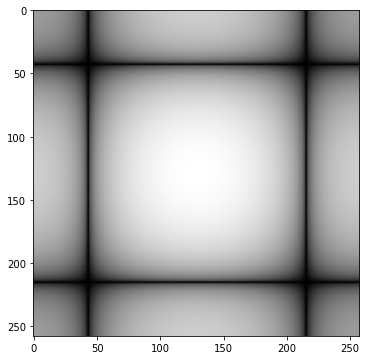

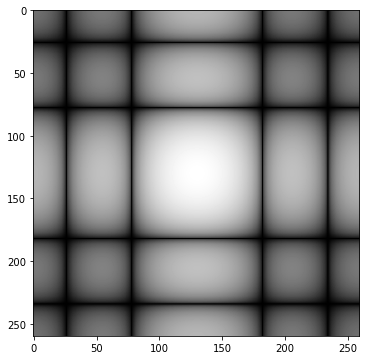

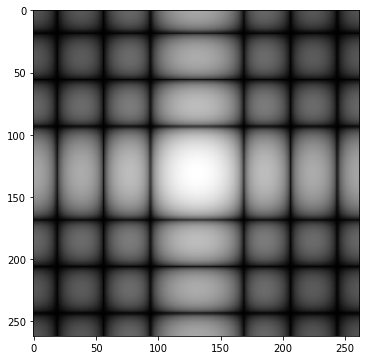

In [8]:
filter3x3 = createKernel(3)
filter5x5 = createKernel(5)
filter7x7 = createKernel(7)

padSize = 256
pad = np.arange(padSize*padSize).reshape(padSize,padSize)
# multiplying with 255 is for stretch the interval from 0-1 to 0-255
zeroP_fltr3x3 = imagePad(filter3x3*255,pad)
zeroP_fltr5x5 = imagePad(filter5x5*255,pad)
zeroP_fltr7x7 = imagePad(filter7x7*255,pad)

ft3 = toVisualizeLogFT(computeFT(zeroP_fltr3x3))
ft5 = toVisualizeLogFT(computeFT(zeroP_fltr5x5))
ft7 = toVisualizeLogFT(computeFT(zeroP_fltr7x7))

imshow(ft3)
plt.show()
imshow(ft5)
plt.show()
imshow(ft7)
plt.show()


Interpretation: the transfert function of a mean filter is not an ideal low pass filter.

Performing the same study for the Gaussian kernel with proper $\sigma$ values.

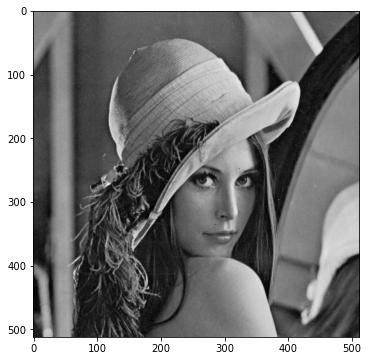

filtering...


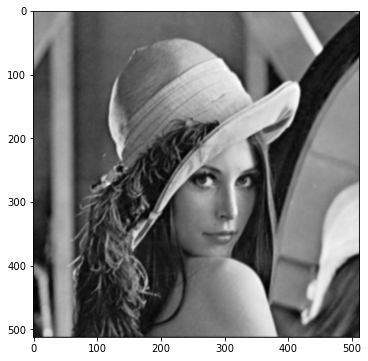

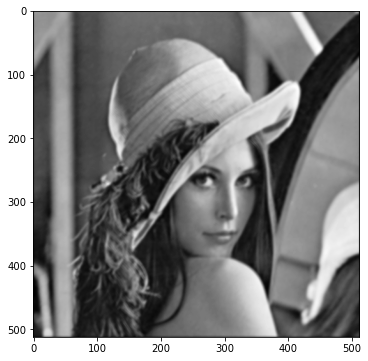

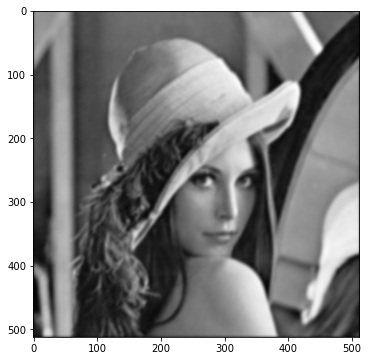

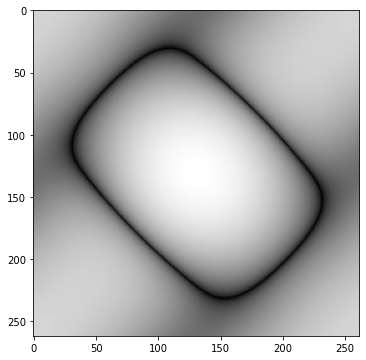

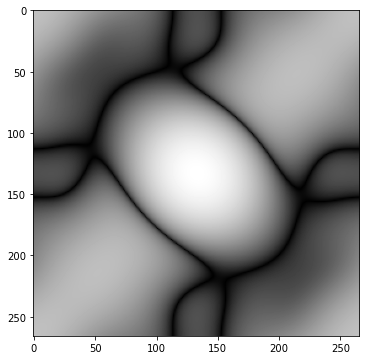

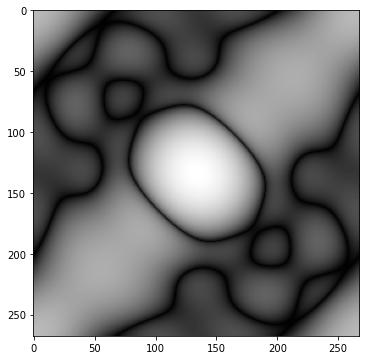

In [9]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

# kernel creation
filter1 = gaussianKernel(1)
filter2 = gaussianKernel(1.5)
filter3 = gaussianKernel(2)

# load image and display
lena = np.array(Image.open('img/lena.jpg'))
imshow(lena)

# filtering process
print("filtering...")
filteredImage1 = conv2(lena,filter1)
filteredImage2 = conv2(lena,filter2)
filteredImage3 = conv2(lena,filter3)

# visualize the results
imshow(filteredImage1)
plt.show()
imshow(filteredImage2)
plt.show()
imshow(filteredImage3)
plt.show()

# padding process
padSize = 256
pad = np.arange(padSize*padSize).reshape(padSize,padSize)
# multiplying with 255 is for change the interval from 0-1 to 0-255
zeroP_fltr1 = imagePad(filter1*255,pad)
zeroP_fltr2 = imagePad(filter2*255,pad)
zeroP_fltr3 = imagePad(filter3*255,pad)

# calculation of transfer functions
ft1 = toVisualizeLogFT(computeFT(zeroP_fltr1))
ft2 = toVisualizeLogFT(computeFT(zeroP_fltr2))
ft3 = toVisualizeLogFT(computeFT(zeroP_fltr3))

# visualize the results
imshow(ft1)
plt.show()
imshow(ft2)
plt.show()
imshow(ft3)
plt.show()

## Anti Aliasing Filtering

In [ ]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A



In [ ]:
image = np.array(Image.open('img/barbara.png'))

# subsample without filtering
subsampledImage = subSample2(image)
imshow(subsampledImage)

# filtering process
spectrum = fftshift(computeFT(image))
AAFilter = antiAliasingFilter(image.shape[0],image.shape[1])
filteredSpectrum = spectrum*AAFilter
IDFT = ifft2(ifftshift(filteredSpectrum))
filteredImage = IDFT.real

# subsample with filtering
subsampledImage = subSample2(filteredImage)
imshow(subsampledImage)

General principle of filtering in the frequency domain is to modify some signal frequency components. For the lowpass filtering, this principle is to attenuate high frequencies and preserve low frequencies.


Without filtering;
Some signal frequencies are changed(corrupted) because of the reduction of spatial grid. This is why we are
seeing some lines in different directions.
    
With filtering;
Simply, we have lost some high frequencies, so the limit frequency is decreased. This is why we don't observe
any jagging or lines because now we satisfy the shannon condition which is fs >= 2*fmax. And also image sharpness is
decreased because flitered high frequencies were representing the details in the image.

## Color Image

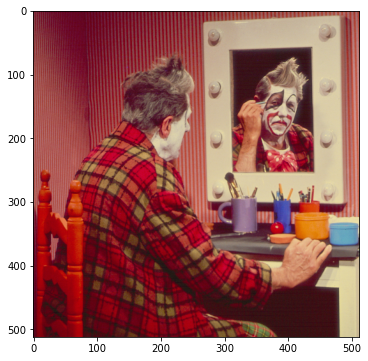

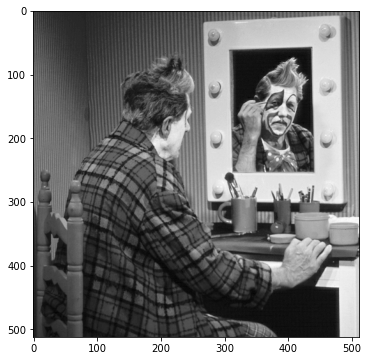

In [86]:
clown = np.array(Image.open('img/clown.bmp'))
clown_lumi = np.array(Image.open('img/clown_lumi.bmp'))
imshow(clown)
imshow(clown_lumi)


# The only difference between these images is color representation. first image has RGB color space, the second
# one has grayscale color space. First image has 3 dimension. One for red, one for green and one for blue.
# The second one has only one dimension which is grayscale.


Let's seperate these 3 dimensions and examine the signification of each dimension.

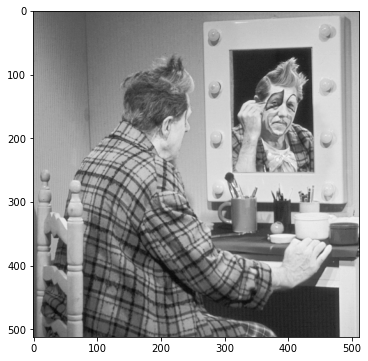

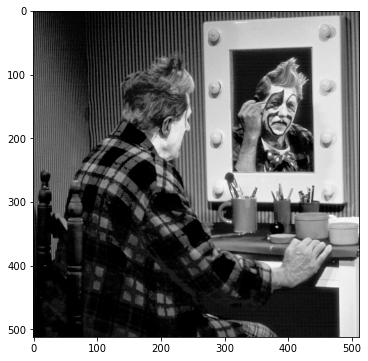

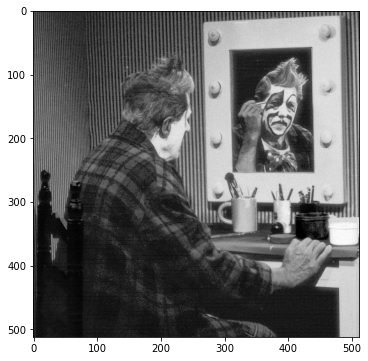

In [88]:
IR = clown[:,:,0]
IG = clown[:,:,1]
IB = clown[:,:,2]
imshow(IR)
imshow(IG)
imshow(IB)

Each dimension express the participation of that color. all dimension are important and they represent the colors of the objects in the image only when they are all blended together. Same images except different contrasts. We can say that the percentages of the colors in the image are R>B>G according to the intensities of IR,IG and IB.

\
Playing with dimensions...

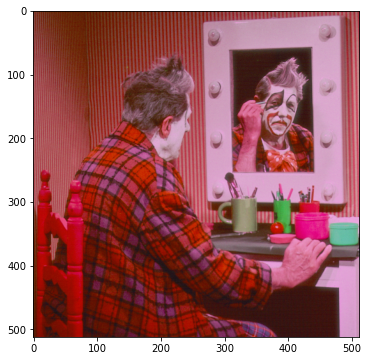

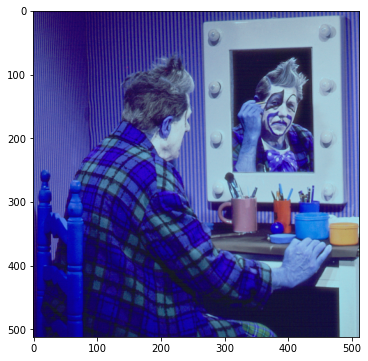

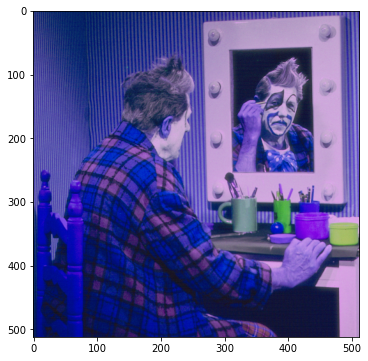

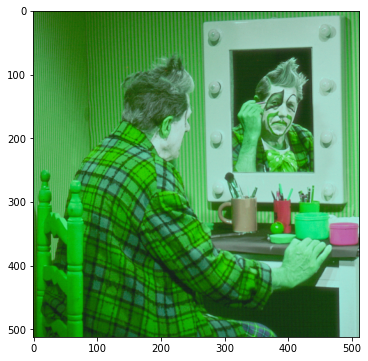

In [89]:
I3 = np.zeros((512,512,3))
I3[:,:,0] = IR/255.
I3[:,:,1] = IB/255.
I3[:,:,2] = IG/255.
imshow(I3)
I3[:,:,0] = IB/255.
I3[:,:,1] = IG/255.
I3[:,:,2] = IR/255.
imshow(I3)
I3[:,:,0] = IG/255.
I3[:,:,1] = IB/255.
I3[:,:,2] = IR/255.
imshow(I3)
I3[:,:,0] = IB/255.
I3[:,:,1] = IR/255.
I3[:,:,2] = IG/255.
imshow(I3)

A function to be able to see each dimension/channel with its own color...

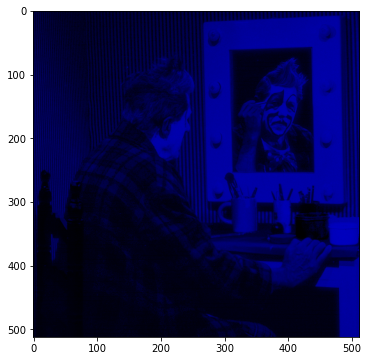

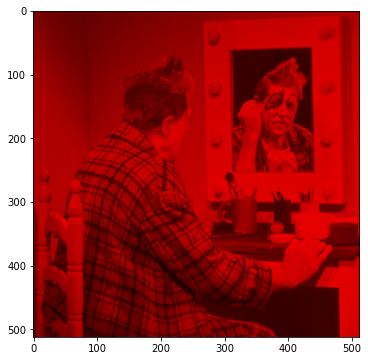

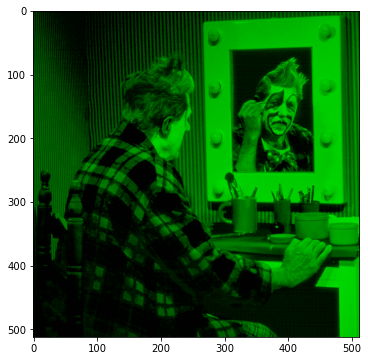

In [90]:
def showChannel(img,channel):
    imgC = np.zeros((img.shape[0],img.shape[1],3))
    if channel == 'r':
        imgC[:,:,0] = img[:,:,0]/255.
        imgC[:,:,1] = 0/255.
        imgC[:,:,2] = 0/255.
        imshow(imgC)
    elif channel == 'g':
        imgC[:,:,0] = 0/255.
        imgC[:,:,1] = img[:,:,1]/255.
        imgC[:,:,2] = 0/255.
        imshow(imgC)
    elif channel == 'b':
        imgC[:,:,0] = 0/255.
        imgC[:,:,1] = 0/255.
        imgC[:,:,2] = img[:,:,2]/255.
        imshow(imgC)
    else:
        print('invalid channel!')

#test
showChannel(clown,'b')
showChannel(clown,'r')
showChannel(clown,'g')